# Azure Kubernetes Service (AKS) Deep MNIST
In this example we will deploy a tensorflow MNIST model in the Azure Kubernetes Service (AKS).

This tutorial will break down in the following sections:

1) Train a tensorflow model to predict mnist locally

2) Containerise the tensorflow model with our docker utility

3) Send some data to the docker model to test it

4) Install and configure Azure tools to interact with your cluster

5) Use the Azure tools to create and setup AKS cluster with Seldon

6) Push and run docker image through the Azure Container Registry

7) Test our Elastic Kubernetes deployment by sending some data

Let's get started! 🚀🔥

## Dependencies:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* az CLI v2.0.66+
* Python 3.6+
* Python DEV requirements


## 1) Train a tensorflow model to predict mnist locally
We will load the mnist images, together with their labels, and then train a tensorflow model to predict the right labels

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
import tensorflow as tf

if __name__ == '__main__':
    
    x = tf.placeholder(tf.float32, [None,784], name="x")

    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))

    y = tf.nn.softmax(tf.matmul(x,W) + b, name="y")

    y_ = tf.placeholder(tf.float32, [None, 10])

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    init = tf.initialize_all_variables()

    sess = tf.Session()
    sess.run(init)

    for i in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_:mnist.test.labels}))

    saver = tf.train.Saver()

    saver.save(sess, "model/deep_mnist_model")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

## 2) Containerise the tensorflow model with our docker utility

First you need to make sure that you have added the .s2i/environment configuration file in this folder with the following content:

In [2]:
!cat .s2i/environment

MODEL_NAME=DeepMnist
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0


Now we can build a docker image named "deep-mnist" with the tag 0.1

In [2]:
!s2i build . seldonio/seldon-core-s2i-python36:1.5.0-dev deep-mnist:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## 3) Send some data to the docker model to test it
We first run the docker image we just created as a container called "mnist_predictor"

In [3]:
!docker run --name "mnist_predictor" -d --rm -p 5000:5000 deep-mnist:0.1

9087047e368ac8f285e1f742704b4c0c7bceac7d29ee90b3b0a6ef2d61ebd15c


Send some random features that conform to the contract

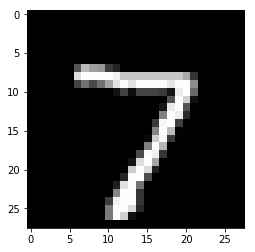

Expected label:  7.0 . One hot encoding:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [6]:
import matplotlib.pyplot as plt
import numpy as np
# This is the variable that was initialised at the beginning of the file
i = [0]
x = mnist.test.images[i]
y = mnist.test.labels[i]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
print("Expected label: ", np.sum(range(0,10) * y), ". One hot encoding: ", y)

In [7]:
from seldon_core.seldon_client import SeldonClient
import math
import numpy as np

# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:5000"
batch = x
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)

# We use the microservice, instead of the "predict" function
client_prediction = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

for proba, label in zip(client_prediction.response.data.ndarray.values[0].list_value.ListFields()[0][1], range(0,10)):
    print(f"LABEL {label}:\t {proba.number_value*100:6.4f} %")

LABEL 0:	 0.0064 %
LABEL 1:	 0.0000 %
LABEL 2:	 0.0155 %
LABEL 3:	 0.2862 %
LABEL 4:	 0.0003 %
LABEL 5:	 0.0027 %
LABEL 6:	 0.0000 %
LABEL 7:	 99.6643 %
LABEL 8:	 0.0020 %
LABEL 9:	 0.0227 %


In [8]:
!docker rm mnist_predictor --force

mnist_predictor


## 4) Install and configure Azure tools 

First we install the azure cli - follow specific instructions at https://docs.microsoft.com/en-us/cli/azure/install-azure-cli?view=azure-cli-latest

In [ ]:
!curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash

### Configure the azure CLI so it can talk to your server 
(if you are getting issues, make sure you have the permmissions to create clusters)

You must run this through a terminal and follow the instructions:
```
az login
```

Once you are logged in, we can create our cluster. Run the following command, it may take a while so feel free to get a ☕.

In [ ]:
%%bash 
# We'll create a resource group
az group create --name SeldonResourceGroup --location westus
# Now we create the cluster
az aks create \
    --resource-group SeldonResourceGroup \
    --name SeldonCluster \
    --node-count 1 \
    --enable-addons monitoring \
    --generate-ssh-keys
    --kubernetes-version 1.13.5

Once it's created we can authenticate our local `kubectl` to make sure we can talk to the azure cluster:

In [ ]:
!az aks get-credentials --resource-group SeldonResourceGroup --name SeldonCluster

And now we can check that this has been successful by making sure that our `kubectl` context is pointing to the cluster:

In [ ]:
!kubectl config get-contexts

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core). Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html).

## Push docker image
In order for the EKS seldon deployment to access the image we just built, we need to push it to the Azure Container Registry (ACR) - you can check if it's been successfully created in the dashboard https://portal.azure.com/#blade/HubsExtension/BrowseResourceBlade/resourceType/Microsoft.ContainerRegistry%2Fregistries

If you have any issues please follow the official Azure documentation: https://docs.microsoft.com/en-us/azure/container-registry/container-registry-get-started-azure-cli

### First we create a registry
Make sure you keep the `loginServer` value in the output dictionary as we'll use it below.

In [14]:
!az acr create --resource-group SeldonResourceGroup --name SeldonContainerRegistry --sku Basic

{- Finished ..
  "adminUserEnabled": false,
  "creationDate": "2019-06-06T10:51:55.288108+00:00",
  "id": "/subscriptions/df7969cc-8033-4c83-b027-14c0424f039d/resourceGroups/KlawClusterResourceGroup/providers/Microsoft.ContainerRegistry/registries/SeldonContainerRegistry",
  "location": "westus",
  "loginServer": "seldoncontainerregistry.azurecr.io",
  "name": "SeldonContainerRegistry",
  "networkRuleSet": null,
  "provisioningState": "Succeeded",
  "resourceGroup": "KlawClusterResourceGroup",
  "sku": {
    "name": "Basic",
    "tier": "Basic"
  },
  "status": null,
  "storageAccount": null,
  "tags": {},
  "type": "Microsoft.ContainerRegistry/registries"
}


### Make sure your local docker instance has access to the registry

In [15]:
!az acr login --name SeldonContainerRegistry

Login Succeeded
WARNING! Your password will be stored unencrypted in /home/alejandro/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



### Now prepare docker image
We need to first tag the docker image before we can push it.

NOTE: if you named your registry different make sure you change the value of `seldoncontainerregistry.azurecr.io`

In [18]:
!docker tag deep-mnist:0.1 seldoncontainerregistry.azurecr.io/deep-mnist:0.1

### And push the image

NOTE: if you named your registry different make sure you change the value of `seldoncontainerregistry.azurecr.io`

In [19]:
!docker push seldoncontainerregistry.azurecr.io/deep-mnist:0.1

The push refers to repository [seldoncontainerregistry.azurecr.io/deep-mnist]

b4fe3076: Preparing 
e4a983d1: Preparing 
74b2c556: Preparing 
9472b523: Preparing 
a2a7ea60: Preparing 
eddb328a: Preparing 
1393f8e7: Preparing 
67d6e30e: Preparing 
f19da2c9: Preparing 
9ec591c4: Preparing 
32b1ff99: Preparing 
64f96dbc: Preparing 
e6d76fd9: Preparing 
11a84ad4: Preparing 
4b2c556: Pushing  187.1MB/648.8MBPushing   28.9MB/648.8MBPushing  60.12MB/141.8MBPushing  60.64MB/141.8MBPushing  141.9MBPushing  185.5MB/648.8MB32b1ff99: Pushed   570.6MB/556.5MBPushing  254.7MB/556.5MBPushing  268.7MB/648.8MBPushing  6.456MB/100.6MBPushing  345.2MB/648.8MBPushing  398.1MB/648.8MBPushing  55.64MB/100.6MBPushing  481.1MB/648.8MBPushing  473.8MB/556.5MB0.1: digest: sha256:b6110da62719e103bfd8c4b187f868b4341c35be16d288018d529da1cfa2585c size: 3482


## Running the Model
We will now run the model. As you can see we have a placeholder `"REPLACE_FOR_IMAGE_AND_TAG"`, which we'll replace to point to our registry.

Let's first have a look at the file we'll be using to trigger the model:

In [20]:
!cat deep_mnist.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "deep-mnist"
    },
    "spec": {
        "annotations": {
            "project_name": "Tensorflow MNIST",
            "deployment_version": "v1"
        },
        "name": "deep-mnist",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "REPLACE_FOR_IMAGE_AND_TAG",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
         

Now let's trigger seldon to run the model.

### Run the deployment in your cluster

NOTE: In order for this to work you need to make sure that your cluster has the permissions to pull the images. You can do this by:

1) Go into the Azure Container Registry

2) Select the SeldonContainerRegistry you created

3) Click on "Add a role assignment"

4) Select the AcrPull role

5) Select service principle

6) Find the SeldonCluster

7) Wait until the role has been added

We basically have a yaml file, where we want to replace the value "REPLACE_FOR_IMAGE_AND_TAG" for the image you pushed

In [33]:
%%bash
# Change accordingly if your registry is called differently
sed 's|REPLACE_FOR_IMAGE_AND_TAG|seldoncontainerregistry.azurecr.io/deep-mnist:0.1|g' deep_mnist.json | kubectl apply -f -

seldondeployment.machinelearning.seldon.io/deep-mnist created


And let's check that it's been created.

You should see an image called "deep-mnist-single-model...".

We'll wait until STATUS changes from "ContainerCreating" to "Running"

In [ ]:
!kubectl get pods

## Test the model
Now we can test the model, let's first find out what is the URL that we'll have to use:

In [43]:
!kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].ip}'  

52.160.64.65

We'll use a random example from our dataset

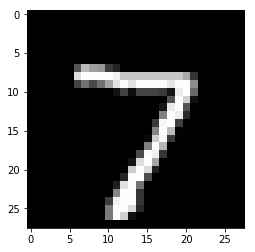

Expected label:  7.0 . One hot encoding:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [35]:
import matplotlib.pyplot as plt
# This is the variable that was initialised at the beginning of the file
i = [0]
x = mnist.test.images[i]
y = mnist.test.labels[i]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
print("Expected label: ", np.sum(range(0,10) * y), ". One hot encoding: ", y)

We can now add the URL above to send our request:

In [44]:
from seldon_core.seldon_client import SeldonClient
import math
import numpy as np

host = "52.160.64.65"
port = "80" # Make sure you use the port above
batch = x
payload_type = "ndarray"

sc = SeldonClient(
    gateway="ambassador", 
    ambassador_endpoint=host + ":" + port,
    namespace="default")

client_prediction = sc.predict(
    data=batch, 
    deployment_name="deep-mnist",
    names=["text"],
    payload_type=payload_type)

print(client_prediction)

Success:True message:
Request:
data {
  names: "text"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
     

### Let's visualise the probability for each label
It seems that it correctly predicted the number 7

In [45]:
for proba, label in zip(client_prediction.response.data.ndarray.values[0].list_value.ListFields()[0][1], range(0,10)):
    print(f"LABEL {label}:\t {proba.number_value*100:6.4f} %")

LABEL 0:	 0.0064 %
LABEL 1:	 0.0000 %
LABEL 2:	 0.0155 %
LABEL 3:	 0.2862 %
LABEL 4:	 0.0003 %
LABEL 5:	 0.0027 %
LABEL 6:	 0.0000 %
LABEL 7:	 99.6643 %
LABEL 8:	 0.0020 %
LABEL 9:	 0.0227 %
